<a href="https://colab.research.google.com/github/ogniandantchev/dilated_causal_cnn_time_series/blob/master/02_GRU_RNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multivariate Time Series Forecasting with Keras and TensorFlow


continued from Notebook 01



## 02. Gated Recurrent Unit (GRU) RNN Model Implementation


### Contents

* read data and check -- plot random intervals 
* split data
* scale data
* Data Generator helper function
* validation set
* Create the GRU Model
* Custom loss (MSE) function
* Compile the model
* Callback functions -- optimize LR, record checkpoints
* Train the Recurrent Neural Network
* Load checkpoint, in case of early stop
* Performance on Test set
* Generate predictions


Technical Note: It's recommended to run this Notebook 02 in Colab or locally w/ CUDA GPU.

In [0]:
import pandas as pd
import numpy as np

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [0]:
#from google.colab import drive
#drive.mount("/content/gdrive")


#from google.colab import files
#files.download('cp.ckpt')

In [0]:
#!ls {"/home/o/Documents"} # for the dl1
!ls {"/Users/oggy/Documents/dl101"} # for the MacBook Pro

01_Prepare_the_dataset.ipynb
02_GRU_RNN_model.ipynb
1609.03499.pdf
23_Time-Series-Prediction.ipynb
3138627798433dat.html
3138627798433dat.txt
3138627798433dat.txt.zip
3138627798433inv.txt
3138627798433stn.txt
3505doc.txt
A_Tour_of_C++_2nd_Edition.epub
CDO2282927798399.txt
DCCNN_model.ipynb
Deep Learning with Python - A Hands-on Introduction - 1E (2017).pdf
Francois Chollet - Deep Learning with Python - 2017.epub
Francois Chollet - Deep Learning with Python - 2017.pdf
GRU_model-Copy1.ipynb
Hands.Machine.Learning.Scikit.Learn.Tensorflow.4.pdf
IMG_0430.jpg
Image 3.12.18 at 22.14.jpg
Mastering.Predictive.Analytics.Scikit.Learn.Tensorflow.9.epub
RNN_time_series.ipynb
Tensorflow.Machine.Learning.Cookbook.Intelligent.12.epub
Untitled.ipynb
deep_learning_time_series_forecasting_mini_course.pdf
ff-kat-mg-data
logs
noaa_ncei_data.txt
prepare_dataset.ipynb
weather.npy
weather.py
weather_VAR_SOF


In [0]:
# read from DL1 PC
#test2 = pd.read_pickle("/home/o/Documents/weather_VAR_SOF")

# read from MacBook Pro
test2 = pd.read_pickle("/Users/oggy/Documents/dl101/weather_VAR_SOF")

# read from Google Drive
#test2 = pd.read_pickle("/content/gdrive/My Drive/weather_VAR_SOF")


#with open('/content/gdrive/My Drive/test', 'r') as f:
#  f.write('Hello Google Drive!')

In [0]:
test2.head()

Varna                Sofia              Various     
                      Temp, C     SLP, hPa Temp, C     SLP, hPa     Day Hour
Date_Time                                                                   
1973-01-01 00:00:00 -2.780000  1046.300000   -3.89  1047.100000       1    0
1973-01-01 01:00:00 -3.520000  1046.266667   -3.89  1047.133333       1    1
1973-01-01 02:00:00 -4.260000  1046.233333   -3.89  1047.166667       1    2
1973-01-01 03:00:00 -5.000000  1046.200000   -3.89  1047.200000       1    3
1973-01-01 04:00:00 -3.981667  1046.566667   -5.00  1047.466667       1    4

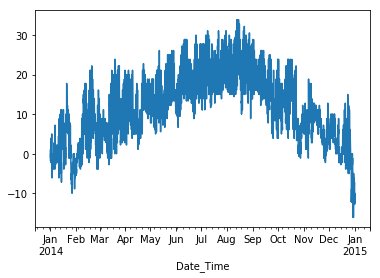

In [0]:
test2["Sofia"]["Temp, C"]['2014-01':'2014-12'].plot()

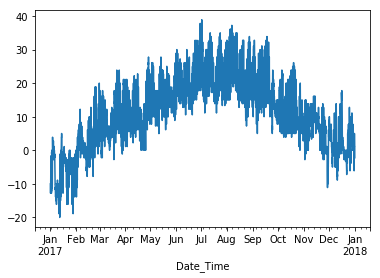

In [0]:
test2["Sofia"]["Temp, C"]['2017-01':'2017-12'].plot()

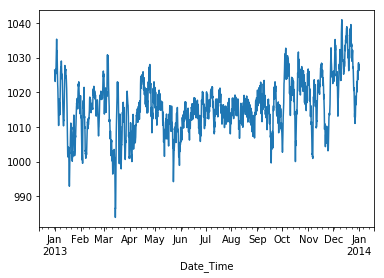

In [0]:
test2["Sofia"]["SLP, hPa"]['2013-01':'2013-12'].plot()

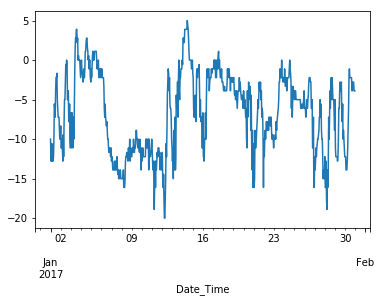

In [0]:
test2["Sofia"]["Temp, C"]['2017-01-01':'2017-01-30'].plot()

In [0]:
test2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 401784 entries, 1973-01-01 00:00:00 to 2018-11-01 23:00:00
Freq: H
Data columns (total 6 columns):
(Varna, Temp, C)     401784 non-null float64
(Varna, SLP, hPa)    401784 non-null float64
(Sofia, Temp, C)     401784 non-null float64
(Sofia, SLP, hPa)    401784 non-null float64
(Various, Day)       401784 non-null int64
(Various, Hour)      401784 non-null int64
dtypes: float64(4), int64(2)
memory usage: 21.5 MB


In [0]:
target_city = "Sofia"

In [0]:
target_names = ["Temp, C"]

In [0]:
shift_days = 3
shift_steps = shift_days * 24  # Number of hours.

In [0]:
df_targets = test2[target_city][target_names].shift(-shift_steps)

In [0]:
test2.head(72)

Varna                  Sofia              Various     
                      Temp, C     SLP, hPa   Temp, C     SLP, hPa     Day Hour
Date_Time                                                                     
1973-01-01 00:00:00 -2.780000  1046.300000 -3.890000  1047.100000       1    0
1973-01-01 01:00:00 -3.520000  1046.266667 -3.890000  1047.133333       1    1
1973-01-01 02:00:00 -4.260000  1046.233333 -3.890000  1047.166667       1    2
1973-01-01 03:00:00 -5.000000  1046.200000 -3.890000  1047.200000       1    3
1973-01-01 04:00:00 -3.981667  1046.566667 -5.000000  1047.466667       1    4
1973-01-01 05:00:00 -2.963333  1046.933333 -6.110000  1047.733333       1    5
1973-01-01 06:00:00 -1.945000  1047.300000 -7.220000  1048.000000       1    6
1973-01-01 07:00:00 -0.926667  1047.300000 -5.553333  1047.600000       1    7
1973-01-01 08:00:00  0.091667  1047.300000 -3.886667  1047.200000       1    8
1973-01-01 09:00:00  1.110000  1047.300000 -2.220000  1046.800000       1    9
1973-01-01 10:00:00  2.776667  1047.100000 -0.183333  1045.700000       1   10
1973-01-01 11:00:00  4.443333  1046.900000  1.853333  1044.600000       1   11
1973-01-01 12:00:00  6.110000  1046.700000  3.890000  1043.500000       1   12
1973-01-01 13:00:00  5.740000  1046.666667  2.963333  1043.833333       1   13
1973-01-01 14:00:00  5.370000  1046.633333  2.036667  1044.166667       1   14
1973-01-01 15:00:00  5.000000  1046.600000  1.110000  1044.500000       1   15
1973-01-01 16:00:00  4.073333  1046.566667  0.740000  1044.733333       1   16
1973-01-01 17:00:00  3.146667  1046.533333  0.370000  1044.966667       1   17
1973-01-01 18:00:00  2.220000  1046.500000  0.000000  1045.200000       1   18
1973-01-01 19:00:00  1.480000  1046.433333 -0.926667  1045.400000       1   19
1973-01-01 20:00:00  0.740000  1046.366667 -1.853333  1045.600000       1   20
1973-01-01 21:00:00  0.000000  1046.300000 -2.780000  1045.800000       1   21
1973-01-01 22:00:00 -0.740000  1045.966667 -3.150000  1045.033333       1   22
1973-01-01 23:00:00 -1.480000  1045.633333 -3.520000  1044.266667       1   23
1973-01-02 00:00:00 -2.220000  1045.300000 -3.890000  1043.500000       2    0
1973-01-02 01:00:00 -2.220000  1044.533333 -3.520000  1043.200000       2    1
1973-01-02 02:00:00 -2.220000  1043.766667 -3.150000  1042.900000       2    2
1973-01-02 03:00:00 -2.220000  1043.000000 -2.780000  1042.600000       2    3
1973-01-02 04:00:00 -1.110000  1042.766667 -2.780000  1042.200000       2    4
1973-01-02 05:00:00  0.000000  1042.533333 -2.780000  1041.800000       2    5
...                       ...          ...       ...          ...     ...  ...
1973-01-02 18:00:00  6.110000  1036.900000 -2.780000  1037.400000       2   18
1973-01-02 19:00:00  6.110000  1036.433333 -2.780000  1037.033333       2   19
1973-01-02 20:00:00  6.110000  1035.966667 -2.780000  1036.666667       2   20
1973-01-02 21:00:00  6.110000  1035.500000 -2.780000  1036.300000       2   21
1973-01-02 22:00:00  5.740000  1034.933333 -2.780000  1035.833333       2   22
1973-01-02 23:00:00  5.370000  1034.366667 -2.780000  1035.366667       2   23
1973-01-03 00:00:00  5.000000  1033.800000 -2.780000  1034.900000       3    0
1973-01-03 01:00:00  4.630000  1033.300000 -2.593333  1034.433333       3    1
1973-01-03 02:00:00  4.260000  1032.800000 -2.406667  1033.966667       3    2
1973-01-03 03:00:00  3.890000  1032.300000 -2.220000  1033.500000       3    3
1973-01-03 04:00:00  3.333333  1032.033333 -2.220000  1033.066667       3    4
1973-01-03 05:00:00  2.776667  1031.766667 -2.220000  1032.633333       3    5
1973-01-03 06:00:00  2.220000  1031.500000 -2.220000  1032.200000       3    6
1973-01-03 07:00:00  3.053333  1031.150000 -1.665000  1031.716667       3    7
1973-01-03 08:00:00  3.886667  1030.800000 -1.110000  1031.233333       3    8
1973-01-03 09:00:00  4.720000  1030.450000 -0.555000  1030.750000       3    9
1973-01-03 10:00:00  5.553333  1030.100000  0.000000  1030.266667       3 

In [0]:
df_targets.tail()

,"Temp, C"
Date_Time,
2018-11-01 19:00:00,NaN
2018-11-01 20:00:00,NaN
2018-11-01 21:00:00,NaN
2018-11-01 22:00:00,NaN
2018-11-01 23:00:00,NaN


In [0]:
#NumPy Arrays

In [0]:
x_data = test2.values[0:-shift_steps]

In [0]:
print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (401712, 6)


In [0]:
y_data = df_targets.values[:-shift_steps]

In [0]:
print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (401712, 1)


In [0]:
num_data = len(x_data)
print(num_data)

train_split = 0.9

#This is the number of observations in the training-set:

num_train = int(train_split * num_data)
print(num_train)

#This is the number of observations in the test-set:

num_test = num_data - num_train
print(num_test)

401712
361540
40172


In [0]:
#This is the number of input-signals:

num_x_signals = x_data.shape[1]
print(num_x_signals)

#This is the number of output-signals:

num_y_signals = y_data.shape[1]
print(num_y_signals)

6
1


In [0]:
#These are the input-signals for the training- and test-sets:

x_train = x_data[0:num_train]
x_test = x_data[num_train:]
print(len(x_train) + len(x_test))

#These are the output-signals for the training- and test-sets:

y_train = y_data[0:num_train]
y_test = y_data[num_train:]
print(len(y_train) + len(y_test))

401712
401712


## Scale Data


The data-set contains a wide range of values:

In [0]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: -25.0
Max: 1070.2


In [0]:
#We first create a scaler-object for the input-signals.


x_scaler = MinMaxScaler()

#We then detect the range of values from the training-data and scale the training-data.

x_train_scaled = x_scaler.fit_transform(x_train)

#Apart from a small rounding-error, the data has been scaled to be between 0 and 1.
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))


Min: 0.0
Max: 1.0


In [0]:
#We use the same scaler-object for the input-signals in the test-set.

x_test_scaled = x_scaler.transform(x_test)
x_test_scaled = x_scaler.transform(x_test)


#The target-data comes from the same data-set as the input-signals, because it is the weather-data for one of the cities that is merely time-shifted. But the target-data could be from a different source with different value-ranges, so we create a separate scaler-object for the target-data.

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)


## Data Generator

The data-set has now been prepared as 2-dimensional numpy arrays. The training-data has over 360k observations, consisting of 6 input signals and 1 output signal.

These are the array-shapes of the input and output data:

In [0]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(361540, 6)
(361540, 1)


Instead of training the Recurrent Neural Network on the complete sequences of almost 300k observations, we will use the following function to create a batch of shorter sub-sequences picked at random from the training-data.

In [0]:
# batch generator function from from [2]
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [0]:
batch_size = 128 #256 #128

# We will use a sequence-length of 1344, which means that each random sequence 
# contains observations for 8 weeks. One time-step corresponds to one hour, so 
# 24 x 7 time-steps corresponds to a week, and 24 x 7 x 8 corresponds to 8 weeks.

sequence_length = 24 * 7 * 4  # 4 weeks  
# 8 weeks

print(sequence_length)

672


In [0]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [0]:
x_batch, y_batch = next(generator)

In [0]:
print(x_batch.shape)
print(y_batch.shape)

(128, 672, 6)
(128, 672, 1)


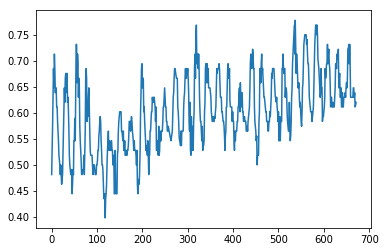

In [0]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 6 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

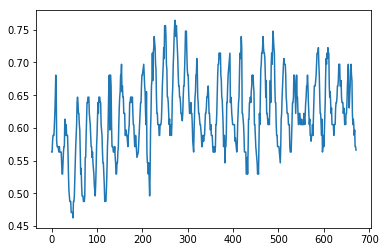

In [0]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

## Validation Set

The neural network trains quickly so we can easily run many training epochs. But then there is a risk of overfitting the model to the training-set so it does not generalize well to unseen data. We will therefore monitor the model's performance on the test-set after each epoch and only save the model's weights if the performance is improved on the test-set.

The batch-generator randomly selects a batch of short sequences from the training-data and uses that during training. But for the validation-data we will instead run through the entire sequence from the test-set and measure the prediction accuracy on that entire sequence.

In [0]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

## Create the Model: Recurrent Neural Network

Data is now ready to create the Recurrent Neural Network (RNN) Model. Keras API is used from TF

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [0]:
import tensorflow as tf
import os

In [0]:
tf.test.gpu_device_name()

''

In [0]:
model = Sequential()

In [0]:
tf.__version__

'1.12.0'

In [0]:
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

In [0]:
model.add(Dense(num_y_signals, activation="tanh"))   #'sigmoid'))

In [0]:
warmup_steps = 50
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

## Compile model

In [0]:
optimizer = RMSprop(lr=1e-3)


#optimizer = tf.train.RMSPropOptimizer(learning_rate=1e-3)
#try tf.train.RMSPropOptimizer 
#as I get this 
#WARNING:tensorflow:This model was compiled with a Keras optimizer 
#(<tensorflow.python.keras.optimizers.RMSprop object at 0x7f1430f445c0>) but is 
#being saved in TensorFlow format with `save_weights`. The model's weights will 
#be saved, but unlike with TensorFlow optimizers in the TensorFlow format the 
#optimizer's state will not be saved.
#Consider using a TensorFlow optimizer from `tf.train`.

#__init__(
#    learning_rate,
#    decay=0.9,
#    momentum=0.0,
#    epsilon=1e-10,
#    use_locking=False,
#    centered=False,
#    name='RMSProp'
#)
# nope, that doesn't work with the callbacks later on...

In [0]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, None, 512)         797184    
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           513       
Total params: 797,697
Trainable params: 797,697
Non-trainable params: 0
_________________________________________________________________


### Callback Functions
During training we want to save checkpoints and log the progress to TensorBoard so we create the appropriate callbacks for Keras.


In [0]:
#This is the callback for writing checkpoints during training.
checkpoint_path = "training_2/cp.ckpt" 
checkpoint_dir = os.path.dirname(checkpoint_path)
# let's see if it really saves OK this time...

path_checkpoint = checkpoint_path
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

#This is the callback for stopping the optimization when performance worsens on the validation-set.


callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=3, verbose=1)  # now that it trains -- my patience should be 3, not 5 

#This is the callback for writing the TensorBoard log during training.


callback_tensorboard = TensorBoard(log_dir='./logs/',
                                   histogram_freq=0,
                                   write_graph=False)

#This callback reduces the learning-rate for the optimizer if the validation-loss has not improved since 
#the last epoch (as indicated by patience=0). The learning-rate will be reduced by multiplying it with 
#the given factor. We set a start learning-rate of 1e-3 above, so multiplying it by 0.1 gives a 
#learning-rate of 1e-4. We don't want the learning-rate to go any lower than this.


callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

## Train the Recurrent Neural Network

We can now train the neural network.

Note that a single "epoch" does not correspond to a single processing of the training-set, because of how the batch-generator randomly selects sub-sequences from the training-set. Instead we have selected `steps_per_epoch` so that one "epoch" is processed in a few minutes.

With these settings, each "epoch" took about 7 minutes to process on Colab free GPU and about 4 on the DL1 PC with 4x GTX 1060.  After 16 "epochs" the optimization was stopped because the validation-loss had not decreased for 5 "epochs". This optimization took about 60 minutes to finish on Colab.

> Also note that the loss sometimes becomes `NaN` (not-a-number). This is often resolved by restarting and running the Notebook again. But it may also be caused by your neural network architecture, learning-rate, batch-size, sequence-length, etc. in which case you may have to modify those settings.  [2]

In [0]:
%%time
history = model.fit_generator(generator=generator,
                    epochs=20,
                    steps_per_epoch=100,
                    validation_data=validation_data,
                    callbacks=callbacks)

# try 
#use_multiprocessing=True, workers=4)
# or this is CPU only?

Epoch 1/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0133
Epoch 00001: val_loss improved from inf to 0.00510, saving model to training_2/cp.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
100/100 [==============================] - 92s 923ms/step - loss: 0.0132 - val_loss: 0.0051
Epoch 2/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0063
Epoch 00002: val_loss did not improve from 0.00510

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
100/100 [==============================] - 89s 894ms/step - loss: 0.0063 - val_loss: 0.0067
Epoch 3/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0044
Epoch 00003: val_loss improved from 0.00510 to 0.00406, saving model to training_2/cp.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
100/100 [==============================] - 87s 870ms/step - loss: 0.0044 - val_loss: 0.0041
Epoch 4/20
 99/100 [============================>.] - ETA: 0s - loss: 

In [0]:
!ls {checkpoint_dir}

checkpoint  cp.ckpt.data-00000-of-00001  cp.ckpt.index


In [0]:
# Save the weights
#model.save_weights('./checkpoints/my_checkpoint')

# Restore the weights
#model = create_model()
#model.load_weights('./checkpoints/my_checkpoint')


model.save('GRU_model.h5')

In [0]:
# one more save experiment
# nb: use locally -- in colab there's no error message, but no saved file too...
file_p = "./test2"
tf.keras.models.save_model(
    model,
    filepath=file_p,
    overwrite=True,
    include_optimizer=True
)

## Load checkpoint

In case of early stop only, reload the last saved checkpoint, which should have the best performance on the test set.

In [0]:
#
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

## Performance on Test Set

We can now evaluate the model's performance on the test set. The function implemented in [2] expects a batch of data.  But we can just use one long time series for the test set, so we just expand the array-dimensionality to create a batch with that one sequence.

In [0]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 7s 7s/step


In [0]:
print("loss (test-set):", result)

loss (test-set): 0.003796208184212446


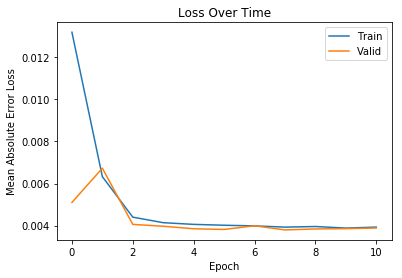

In [0]:
# Plot Loss Over Time for the Training and Validation sets
# The history recording trick history = model.fit... is from [3]
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss') # The custom one, w/warmup
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

## Generate Predictions

This helper-function plots the predicted and true output signals.

In [0]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

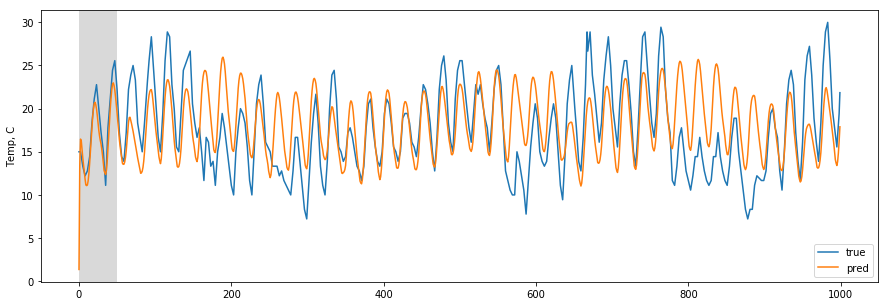

In [0]:
plot_comparison(start_idx=100000, length=1000, train=True)

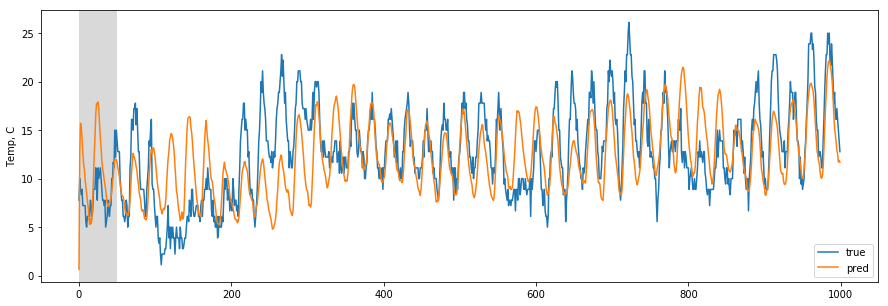

In [0]:
plot_comparison(start_idx=200, length=1000, train=False)

received this message from Colab: close to the memory limit of the free GPU w/12 GB:

```
GPU memory usage is close to the limit

Your GPU is close to its memory limit. You will not be able to use any additional memory in this session. Currently, 10.66 GB / 11.17 GB is being used. Would you like to terminate some sessions in order to free up GPU memory (state will be lost for those sessions)?
```

In [0]:
!ls {checkpoint_dir}

checkpoint  cp.ckpt.data-00000-of-00001  cp.ckpt.index


In [0]:
This table summarizes the training times for the 3 platforms used:

| platform | MacBook Pro | DL1 desktop | Colab Free |
|----------|-------------|-------------|------------|
| OS               | macOS Mojave  | Ubuntu 18.04| Linux |
| CUDA GPU | none        | 4x GP106 6GB| GK210 12GB |
| CPU      | i7 2.9GHz   | P G4400 3GHz| Xeon 2+GHz |
| Time     | 21:00:00 est| 00:29:34    | 00:59:12   |

## References


1. Yordan Darakchiev,  [Deep Learning Course][1], SoftUni



2. Magnus Erik Hvass Pedersen, [TensorFlow-Tutorials][2]
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)



3. Joseph Eddy, [Time Series Forecasting with Convolutional Neural Networks - a Look at WaveNet][3], blog post


4. Aaron van den Oord, Sander Dieleman et al., [WaveNet: A Generative Model for Raw Audio][4]



[1]: https://softuni.bg/trainings/1921/deep-learning-november-2018

[2]: http://www.hvass-labs.org/

[3]: https://jeddy92.github.io/JEddy92.github.io/ts_seq2seq_conv/

[4]: https://arxiv.org/pdf/1609.03499.pdf





Continues to notebook 03.